# DGMC Details

## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

project_root = "/export/share/anatole93dm/src/graph-nmr/"
sys.path.insert(0, project_root)

from dgmc.datasets import PairData, generate_y_t
from dgmc.models import DGMC, GIN, GINE

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import matplotlib.pyplot as plt
import networkx as nx


def visualize_graph(data, title, ax):
    """Convert PyG Data to NetworkX graph and visualize it"""
    G = nx.Graph()

    # Add nodes with their features
    num_nodes = data.x.size(0)
    for i in range(num_nodes):
        G.add_node(i, feature=data.x[i].item(), label=data.y[i].item())

    # Add edges
    edge_index = data.edge_index.t().numpy()
    for edge in edge_index:
        if edge[0] < edge[1]:  # Avoid duplicate edges in undirected graph
            G.add_edge(edge[0], edge[1])

    # Create layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=2000, alpha=1.0)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)

    # Add node labels with features and ground truth
    labels = {}
    for node in G.nodes():
        feature = G.nodes[node]["feature"]
        gt_label = G.nodes[node]["label"]
        labels[node] = f"{node}\nx:{feature}\ny:{gt_label}"

    nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=10)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.axis("off")


def visualize_graph_pair(data_s, data_t, title_s, title_t):
    # Create side-by-side visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Visualize both graphs
    visualize_graph(data_s, title_s, ax1)
    visualize_graph(data_t, title_t, ax2)

    plt.tight_layout()
    plt.show()


def create_pair_data(data_s, data_t):
    data = PairData(
        x_s=data_s.x,
        edge_index_s=data_s.edge_index,
        edge_attr_s=getattr(data_s, 'edge_attr', None),
        label_s=getattr(data_s, 'label', None),
        y_index_s=data_s.y,
        x_t=data_t.x,
        edge_index_t=data_t.edge_index,
        edge_attr_t=getattr(data_s, 'edge_attr', None),
        label_t=getattr(data_s, 'label', None),
        y_t=data_t.y,
        num_nodes=data_s.y.size(0)
    )

    return data

## Graphs

### Graph 1

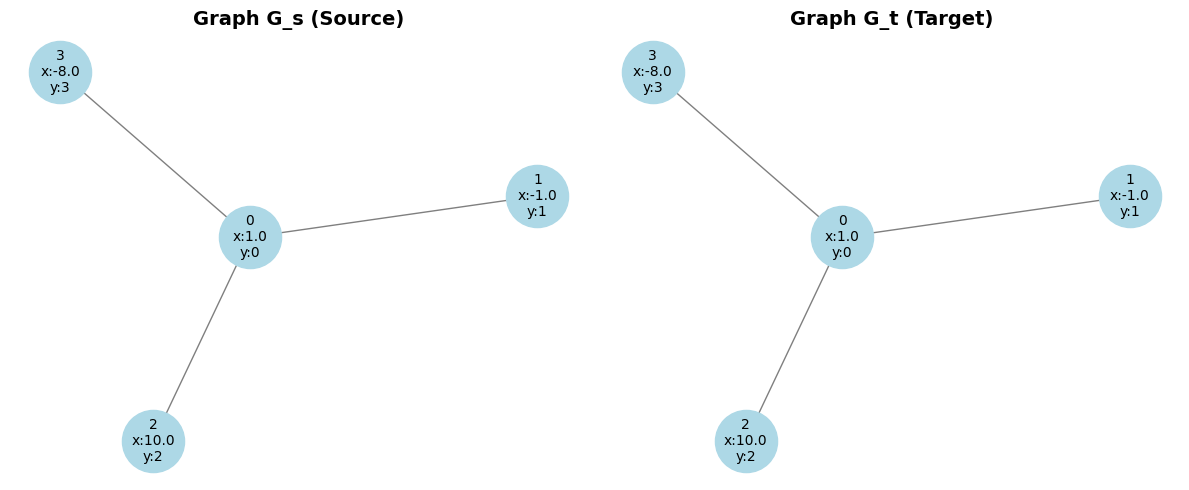

In [3]:
# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_t = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_t = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)

data = create_pair_data(data_s, data_t)
visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 2

In [ ]:
# G_s v2
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([[0], [1], [2], [3]], dtype=torch.long)
y_s_lab = torch.tensor([[3], [0], [1], [2]], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# # G_t v2
edge_index_t = torch.tensor([[0, 1, 1, 2, 1, 3], [1, 0, 2, 1, 3, 1]], dtype=torch.long)
x_t = torch.tensor([[-1], [1], [10], [-8]], dtype=torch.float)
y_t = torch.tensor([[0], [1], [2], [3]], dtype=torch.long)
y_t_lab = torch.tensor([[0], [3], [1], [2]], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)

visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 3

In [ ]:
# G_s v3
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([3, 0, 1, 2], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t v3
edge_index_t = torch.tensor([[0, 1, 1, 2, 1, 3], [1, 0, 2, 1, 3, 1]], dtype=torch.long)
x_t = torch.tensor([[-1], [1], [10], [-8]], dtype=torch.float)
y_t = torch.tensor([0, 3, 1, 2], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)

visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 4

In [ ]:
# G_s v4
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3], [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
y_s = torch.tensor([3, 0, 1, 2], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t v4
edge_index_t = torch.tensor([[0, 2, 3, 2, 2, 1, 2], [2, 0, 2, 3, 1, 2, 4]], dtype=torch.long)
x_t = torch.tensor([[-8], [10], [1], [-1], [5]], dtype=torch.float)
y_t = torch.tensor([2, 1, 3, 0, 4], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)

visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 5

In [ ]:
# G_s
edge_index_s = torch.tensor([[0, 1, 1, 2, 2, 3, 2, 4, 3, 4],
                             [1, 0, 2, 1, 3, 2, 4, 2, 4, 3]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8], [4]], dtype=torch.float)
y_s = torch.tensor([2, 0, 4, 3, 1], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 4, 0, 2, 2, 4, 4, 3, 3, 1],
                             [4, 0, 2, 0, 4, 2, 3, 4, 1, 3]], dtype=torch.long)
x_t = torch.tensor([[-8], [1], [4], [-1], [10]], dtype=torch.float)
y_t = torch.tensor([3, 2, 1, 0, 4], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)

visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 6

In [ ]:
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_s = torch.tensor([[1], [1], [2], [2], [3], [3]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
x_s = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
y_s = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr=edge_attr_s, y=y_s)

edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_t = torch.tensor([[1], [1], [2], [2], [3], [3]], dtype=torch.float)
label_t = ["A", "B", "C", "D"]
x_t = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
y_t = torch.tensor([0, 1, 2, 3], dtype=torch.long)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr=edge_attr_t, y=y_t)


visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 1/1

In [ ]:

# G_s
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_s = torch.tensor([[1], [1], [1], [1], [1], [1]], dtype=torch.float)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
y_s = torch.arange(x_s.size(0))
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr=edge_attr_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_t = torch.tensor([[1], [1], [1], [1], [1], [1]], dtype=torch.float)
x_t = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_t = ["A", "B", "C", "D"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr=edge_attr_s, y=y_t)


visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 2/2

In [ ]:
# G_s v2
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_s = ["A", "B", "C", "D"]
y_s = torch.arange(x_s.size(0))
data_s = Data(x=x_s, edge_index=edge_index_s, label_s=label_s, y=y_s)

# # G_t v2
edge_index_t = torch.tensor([[0, 1, 1, 2, 1, 3],
                             [1, 0, 2, 1, 3, 1]], dtype=torch.long)
x_t = torch.tensor([[-1], [1], [10], [-8]], dtype=torch.float)
label_t = ["B", "A", "C", "D"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, label_t=label_t, y=y_t)

visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 4/4

In [ ]:
# G_s v4
edge_index_s = torch.tensor([[0, 1, 0, 2, 0, 3],
                             [1, 0, 2, 0, 3, 0]], dtype=torch.long)
edge_attr_s = torch.ones(edge_index_s.size(1), 1)
x_s = torch.tensor([[1], [-1], [10], [-8]], dtype=torch.float)
label_s = ["D", "A", "B", "C"]
y_s = torch.arange(x_s.size(0))
data_s = Data(x=x_s, edge_index=edge_index_s, edge_attr_s=edge_attr_s, y=y_s)

# G_t v4
edge_index_t = torch.tensor([[0, 2, 3, 2, 2, 1, 2],
                             [2, 0, 2, 3, 1, 2, 4]], dtype=torch.long)
edge_attr_t = torch.ones(edge_index_t.size(1), 1)
x_t = torch.tensor([[-8], [10], [1], [-1], [5]], dtype=torch.float)
label_t = ["C", "B", "D", "A", "E"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, edge_attr_t=edge_attr_t, y=y_t)

data = create_pair_data(data_s, data_t)
# visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph 5/5

In [ ]:
# G_s
edge_index_s = torch.tensor([[0, 1, 1, 2, 2, 3, 2, 4, 3, 4],
                             [1, 0, 2, 1, 3, 2, 4, 2, 4, 3]], dtype=torch.long)
edge_attr_s = torch.ones(edge_index_s.size(1), 1)
x_s = torch.tensor([[1], [-1], [10], [-8], [4]], dtype=torch.float)
y_s = torch.arange(x_s.size(0))
label_s = ["C", "A", "E", "D", "B"]
data_s = Data(x=x_s, edge_index=edge_index_s, y=y_s)

# G_t
edge_index_t = torch.tensor([[0, 4, 0, 2, 2, 4, 4, 3, 3, 1],
                             [4, 0, 2, 0, 4, 2, 3, 4, 1, 3]], dtype=torch.long)
edge_attr_t = torch.ones(edge_index_t.size(1), 1)
x_t = torch.tensor([[-8], [1], [4], [-1], [10]], dtype=torch.float)
label_t = ["D", "C", "B", "A", "E"]
y_t = generate_y_t(label_s, label_t)
data_t = Data(x=x_t, edge_index=edge_index_t, y=y_t)

visualize_graph_pair(data_s, data_t, "Graph G_s (Source)", "Graph G_t (Target)")

### Graph Protein

In [ ]:
from dgmc.datasets import GraphNmrDataset, pre_transform_to_ones

# Create dataset with pre_transform function to convert x_s and x_t to ones
nmr_dataset = GraphNmrDataset(
    root=f"{project_root}datasets/nmr_graphs_identical",
    pre_transform=pre_transform_to_ones,
    force_reload=True
)
data = nmr_dataset[0]

## Batching

In [22]:
dataset = [data] * 50
dataloader = DataLoader(dataset, batch_size=8, follow_batch=["x_s", "x_t"])
next(iter(dataloader))

PairDataBatch(x_s=[32, 1], x_s_batch=[32], x_s_ptr=[9], edge_index_s=[2, 48], y_index_s=[32], x_t=[32, 1], x_t_batch=[32], x_t_ptr=[9], edge_index_t=[2, 48], y_t=[32], num_nodes=32, batch=[32], ptr=[9])

## Models

### Embeddings, S_hat and S_0

In [10]:
torch.manual_seed(0)
psi_1 = GIN(in_channels=1, out_channels=2, num_layers=1)
model = DGMC(psi_1, psi_1, num_steps=0, norm_embeddings=True).to(device)

data = data.to(device)
S_0, S_L = model(
    data.x_s,
    data.edge_index_s,
    getattr(data, 'edge_attr_s', None),
    None,
    data.x_t,
    data.edge_index_t,
    getattr(data, 'edge_attr_t', None),
    None
)
S_0
# psi_1(data.x_s, data.edge_index_s, getattr(data, 'edge_attr_s', None))

tensor([[0.4751, 0.0957, 0.3511, 0.0781],
        [0.0877, 0.4354, 0.0594, 0.4176],
        [0.3672, 0.0678, 0.4969, 0.0682],
        [0.0727, 0.4242, 0.0607, 0.4423]], device='cuda:0',
       grad_fn=<IndexBackward0>)

### Training

In [ ]:
torch.manual_seed(2)
psi_1 = GIN(in_channels=1, out_channels=32, num_layers=2)
psi_2 = GIN(in_channels=64, out_channels=64, num_layers=2)

model = DGMC(psi_1, psi_2, num_steps=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Run through model
def train():
    total_loss = total_examples = total_correct = 0
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        data = batch.to(device)
        S_0, S_L = model(
            data.x_s,
            data.edge_index_s,
            getattr(data, 'edge_attr_s', None),
            data.x_s_batch,
            data.x_t,
            data.edge_index_t,
            getattr(data, 'edge_attr_t', None),
            data.x_t_batch,
        )

        y = torch.stack([data.y_index_s, data.y_t], dim=0)
        loss = model.loss(S_0, y)
        loss = model.loss(S_L, y) + loss if model.num_steps > 0 else loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += model.acc(S_L, y, reduction="sum")
        total_examples += y.size(1)

    return total_loss / len(dataloader), total_correct / total_examples


for epoch in range(1, 100):
    loss, acc = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.2f}")

# print(S_L)
# correct = model.acc(S_L, y, reduction="sum")
# print(f"Correct: {correct}")

### Evaluation

In [ ]:
torch.manual_seed(2)
psi_1 = GINE(in_channels=1, out_channels=5, num_layers=1)
psi_2 = GINE(in_channels=8, out_channels=16, num_layers=1)

model = DGMC(psi_1, psi_2, num_steps=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Run through model
model.eval()
for batch in dataloader:
    data = batch.to(device)
    S_0, S_L = model(
        data.x_s,
        data.edge_index_s,
        data.edge_attr_s,
        data.x_s_batch,
        data.x_t,
        data.edge_index_t,
        data.edge_attr_t,
        data.x_t_batch,
    )

    y = torch.stack([data.y_index_s, data.y_t], dim=0)
    correct = model.acc(S_0, y, reduction="sum")

    print(S_0)
    print(f"Correct: {correct}")